# Evaluation of CycleGAN models
The quality of our results varied greatly between training runs and different selected training images. We chose our best model for the evaluation. Since we no longer have a ground truth for comparison, as in our previous experiments on black-and-white translation, we will conduct a qualitative assessment of the generated images through visual inspection. For evaluation, we used 64 images taken with a Sony digital camera. We edit these images with both the generator *G* to translate them into the look of Kodak Portra 400 and *F* to translate them into the look of Cinestill 800T.

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.utils as vutils
import torch.nn.functional as F

In [3]:
learning_rate = 1e-4
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

batch_size = 128

# Checkpoint file paths
experiment = "cinestill_800t_portra_400_wo_Identity_loss"
check_G_A2B = "G_A2B.pth.tar"
check_G_B2A = "G_B2A.pth.tar"
check_D_A =  "D_A.pth.tar"
check_D_B = "D_B.pth.tar"

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(128, lut_size * lut_size * lut_size * 3)  # Output LUT values

    def _trilinear_interpolation(self,luts, images):
        # Scale images to be between -1 and 1
        img = (images - 0.5) * 2.0  # Shape: [4, 3, 256, 256]
        
        # Add a singleton dimension to represent "channel" for LUT interpolation
        img = img.permute(0, 2, 3, 1).unsqueeze(1)  # Shape: [4, 1, 256, 256, 3]

        # Ensure LUT is in the correct format
        LUT = luts.permute(0, 4, 1, 2, 3)  # Shape: [4, 3, 8, 8, 8]
        
        # Perform grid sampling for each channel
        result = F.grid_sample(LUT, img, mode='bilinear', padding_mode='border', align_corners=True)  # [4, 3, 1, 256, 256]
    
        # Remove the singleton dimension and permute to the correct format
        result = result.squeeze(2)  # Remove the extra "depth" dimension: [4, 3, 256, 256]
    
        return result

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        x_orig = x
        batch_size = x.size(0)
        features = self.cnn(x)
        features = features.view(features.size(0), -1)  # Flatten
        lut = self.fc(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)

        transformed = self._simple_approach(lut, x_orig)
        return transformed, lut

In [30]:
netG_A2B = ResNetLUTGenerator(lut_size=33).to(device)
netG_B2A = ResNetLUTGenerator(lut_size=33).to(device)

In [31]:
opt_gen = optim.Adam(
    list(netG_A2B.parameters()) + list(netG_B2A.parameters()),
    lr=learning_rate,
    betas=(0.5, 0.999),
)

## Load generators

In [32]:
def load_checkpoint(model, optimizer, experiment, filepath):
    print("=> Loading checkpoint")
    filepath = f"models/{experiment}/{filepath}"
    checkpoint = torch.load(filepath, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [33]:
genA2B, _ = load_checkpoint(netG_A2B, opt_gen, experiment, check_G_A2B)
genB2A, _ = load_checkpoint(netG_B2A, opt_gen, experiment, check_G_B2A)

=> Loading checkpoint
=> Loading checkpoint


## Get Sony test images

In [34]:
class ValDataset(Dataset):
    def __init__(self, val_images, transform=None):
        self.val_images = val_images
        self.transform = transform

    def __len__(self):
        return len(self.val_images)

    def __getitem__(self, idx):
        val_image = self.val_images[idx]
        if self.transform:
            val_image = self.transform(val_image)
        return val_image

In [35]:
transform64 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [17]:
transform = transforms.Compose([transforms.ToTensor()])

In [18]:
def load_images_from_directory(directory_path, num_images=100):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        img = transform64(img)  # Apply the transformations
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

In [20]:
val_images = load_images_from_directory('../../sony_images', num_images=128)

In [21]:
val_dataset = ValDataset(val_images.numpy(), transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [22]:
ev_images = next(iter(val_dataloader))
ev_images = ev_images.to(device)

## Visualization of the original test images

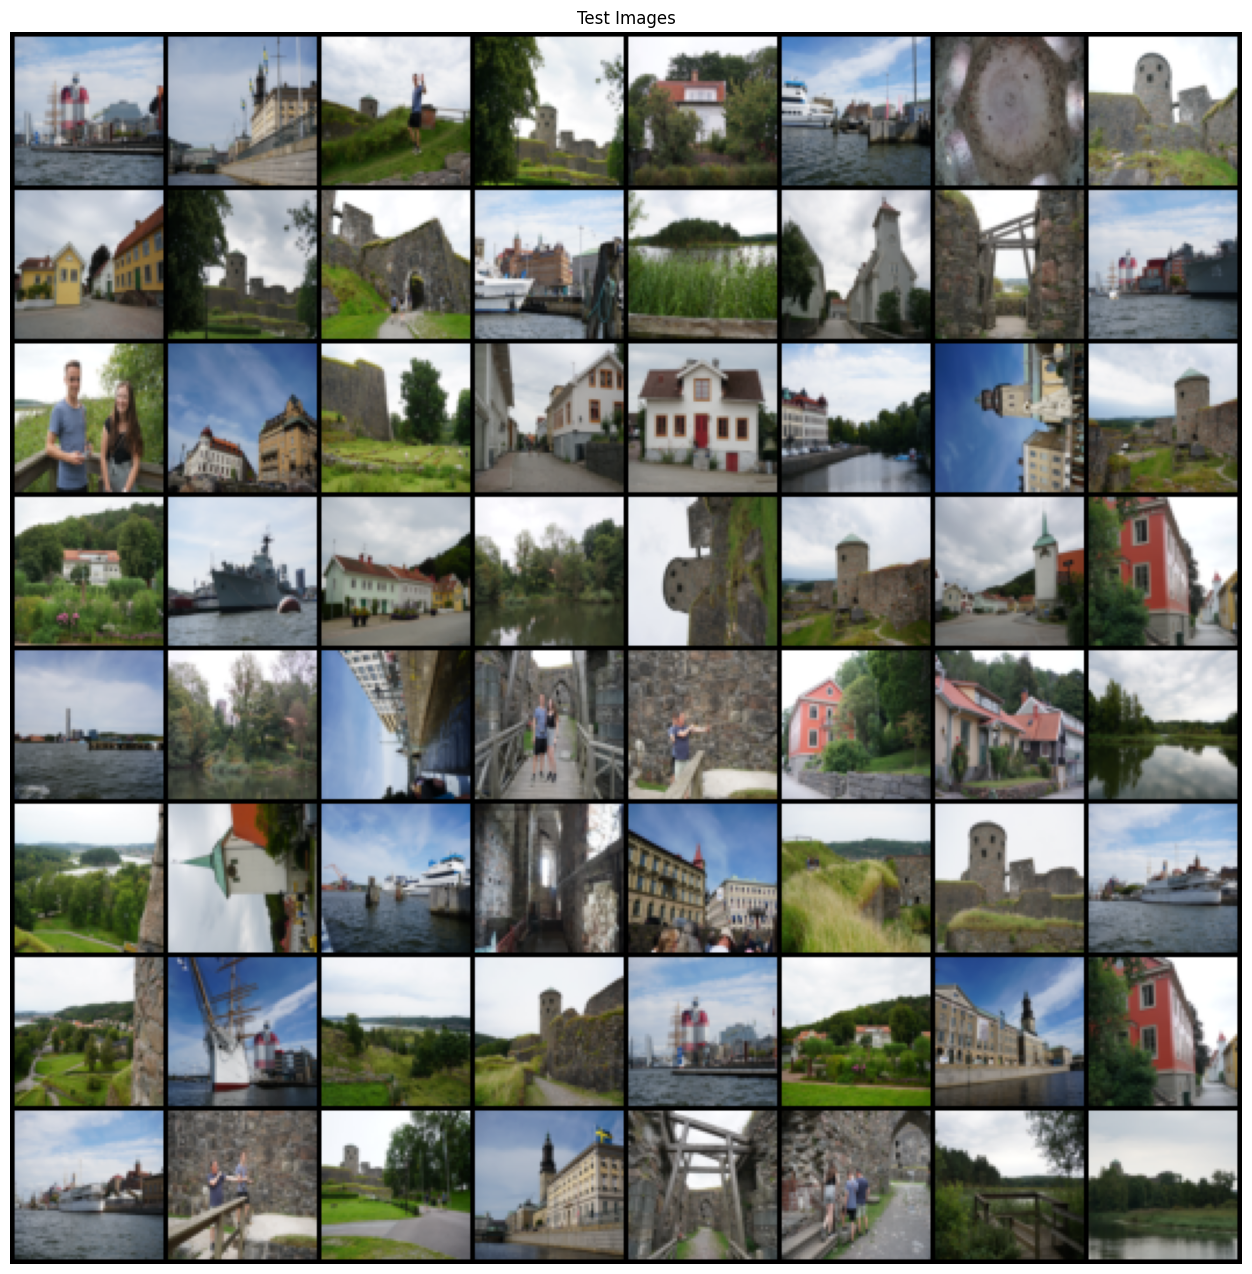

In [23]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Test Images")
plt.imshow(np.transpose(vutils.make_grid(ev_images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [41]:
genA2B.eval()
genB2A.eval()
genA2B.to(device)
genB2A.to(device)

# Test of image transfer in kodak portra
fake_kodak_portra, _ = genA2B(ev_images)

# Test of image transfer in kodak gold
fake_cinestill, _ = genB2A(ev_images)

## Visualization of the edited images translated to Kodak Portra 400

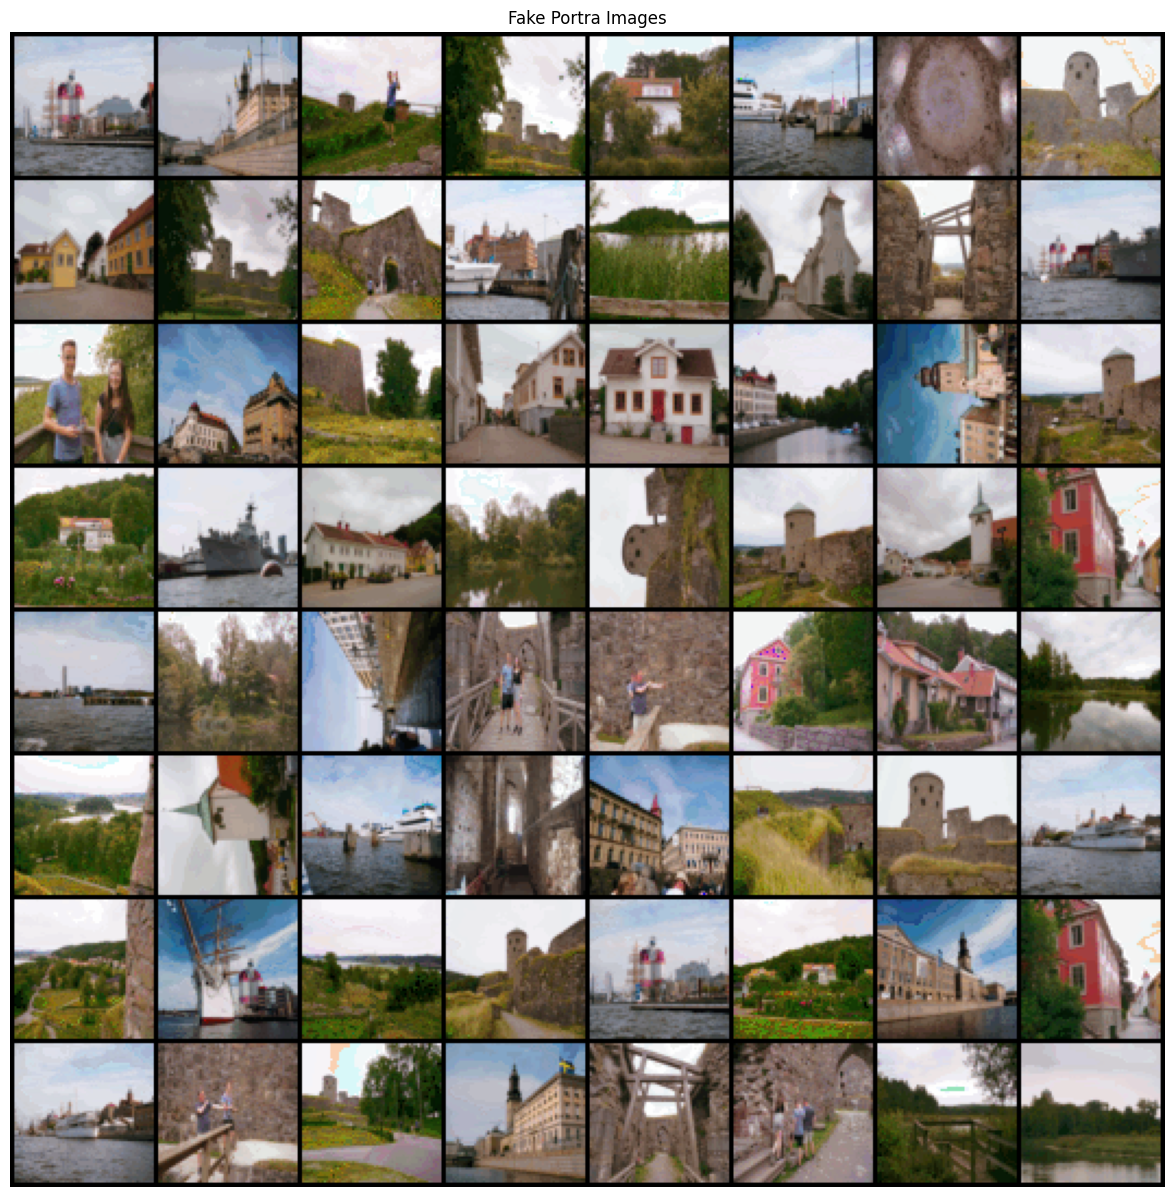

In [37]:
plt.figure(figsize=(16,15))
plt.axis("off")
plt.title("Fake Portra Images")
plt.imshow(np.transpose(vutils.make_grid(fake_kodak_portra.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Visualization of the edited images translated to Cinestill 800T

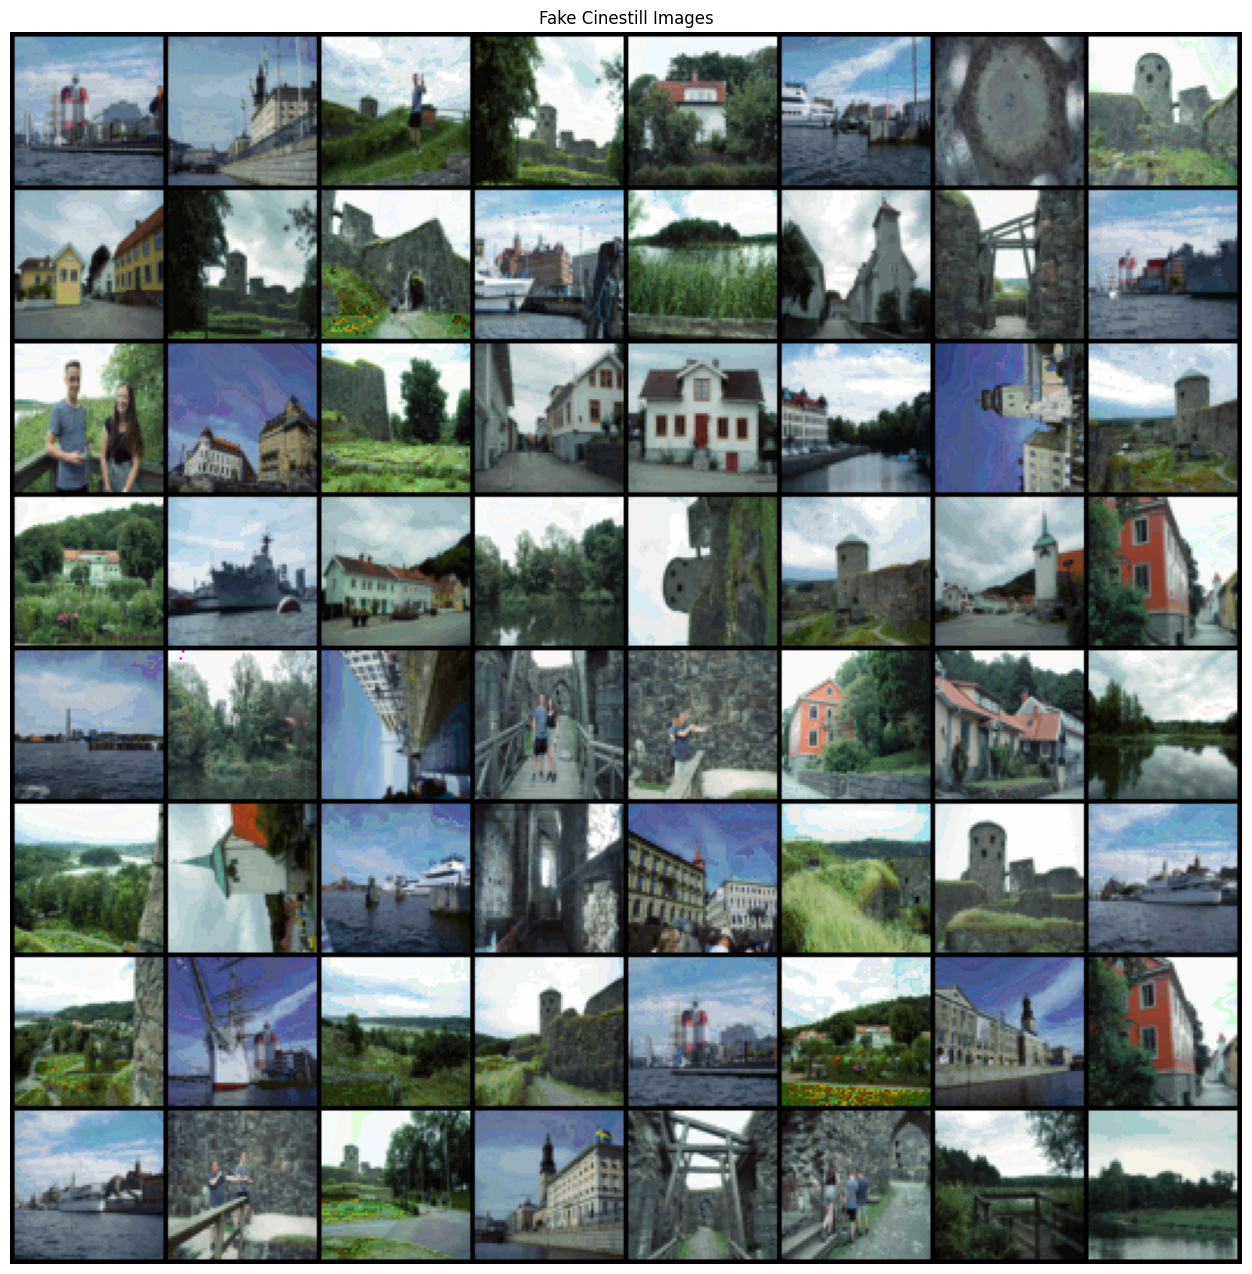

In [42]:
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Fake Cinestill Images")
plt.imshow(np.transpose(vutils.make_grid(fake_cinestill.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## Visualization of a single image

In [40]:
def display_images(images, titles=None):
    # Three subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(9, 5))
    
    # Convert and display each image
    for idx, (ax, img) in enumerate(zip(axes, images)):
        # Convert tensor to numpy array
        tensor_image = img.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        
        # Display the image
        ax.imshow(image_np)
        ax.axis('off')
        
        # Set title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

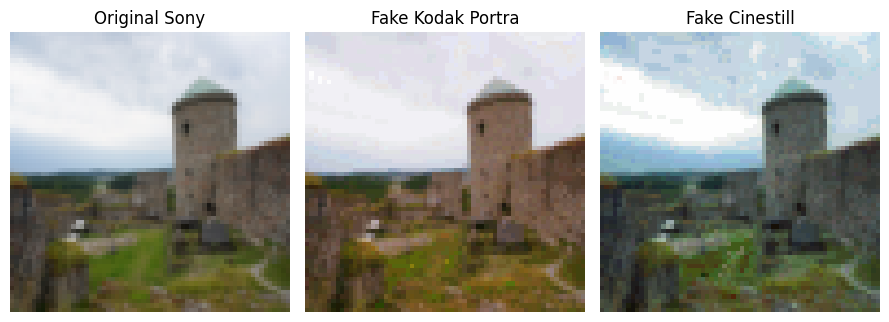

In [56]:
img_id = 23
display_images([ev_images[img_id], fake_kodak_portra[img_id], fake_cinestill[img_id]], ["Original Sony","Fake Kodak Portra", "Fake Cinestill"])